In [1]:
import pymongo
from pymongo import MongoClient
from google.cloud import bigquery
from bson import ObjectId
from google.cloud import bigquery_storage_v1
from functools import partialmethod

import datetime as dt
import pandas as pd
import numpy as np
import requests
import json

from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline  

### Задание 3

In [2]:
client = bigquery.Client.from_service_account_json('./creds.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./creds.json')
project_id = 'goingtoclouds'

sql = '''
SELECT user_id as customer_user_id, platform, media_source, campaign, 
    first_cohort_date as install_date, cpi, transaction_date as visit_date,
    value as revenue 
FROM `goingtoclouds.ltv.pareto_nbd_transactions`
where campaign = 'HC|Android|retention|US' and label = 'actual_data'
    and first_cohort_date <= '2020-09-16' and date_diff(transaction_date,  first_cohort_date, day) <= 14
'''
data = client.query(sql, project=project_id).to_dataframe()
data.to_csv("user_acquisition.csv")

In [3]:
data

customer_user_id platform  media_source                 campaign  \
0               240176  android  unityads_int  HC|Android|retention|US   
1               241706  android  unityads_int  HC|Android|retention|US   
2               245137  android  unityads_int  HC|Android|retention|US   
3               245324  android  unityads_int  HC|Android|retention|US   
4               246732  android  unityads_int  HC|Android|retention|US   
...                ...      ...           ...                      ...   
4764            233428  android  unityads_int  HC|Android|retention|US   
4765            234254  android  unityads_int  HC|Android|retention|US   
4766            234575  android  unityads_int  HC|Android|retention|US   
4767            234578  android  unityads_int  HC|Android|retention|US   
4768            233021  android  unityads_int  HC|Android|retention|US   

     install_date       cpi  visit_date   revenue  
0      2020-09-14  0.958889  2020-09-15  0.117661  
1      2020-09-14  0.958889  2020-09-14  0.273077  
2      2020-09-16  1.800000  2020-09-18  0.326021  
3      2020-09-16  1.304444  2020-09-17  0.029992  
4      2020-09-16  1.344667  2020-09-23  0.035866  
...           ...       ...         ...       ...  
4764   2020-09-11  0.944545  2020-09-16  0.000114  
4765   2020-09-11  0.944545  2020-09-11  0.607027  
4766   2020-09-11  0.996667  2020-09-21  0.229305  
4767   2020-09-11  0.996667  2020-09-18  0.302757  
4768   2020-09-10  0.973077  2020-09-10  0.016468  

[4769 rows x 8 columns]

In [5]:
# Добавляем когортный день
data['cohort_day'] = (data.visit_date-data.install_date).dt.days

# Считаем выручку на каждый день визита
revenue = data.groupby('cohort_day').revenue.sum().reset_index()
revenue['cum_revenue'] = revenue.revenue.cumsum()
revenue['cum_arpu'] = revenue['cum_revenue']/data.customer_user_id.nunique()

revenue

cohort_day     revenue  cum_revenue  cum_arpu
0            0  186.831189   186.831189  0.177596
1            1   98.161753   284.992942  0.270906
2            2   72.994128   357.987071  0.340292
3            3   66.161326   424.148396  0.403183
4            4   50.319261   474.467657  0.451015
5            5   48.513329   522.980986  0.497130
6            6   46.779029   569.760015  0.541597
7            7   41.439141   611.199157  0.580988
8            8   47.430057   658.629214  0.626073
9            9   44.473723   703.102937  0.668349
10          10   38.930202   742.033138  0.705355
11          11   40.361815   782.394953  0.743721
12          12   36.599939   818.994892  0.778512
13          13   38.045398   857.040290  0.814677
14          14   37.039316   894.079606  0.849886

In [6]:
# Считаем CPI
cpi = data[['customer_user_id', 'cpi']].drop_duplicates()
cpi.cpi.sum()/data.customer_user_id.nunique()

1.1740830656050043

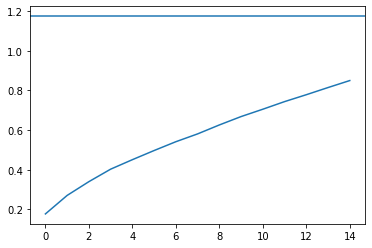

In [7]:
plt.plot(revenue.cohort_day, revenue.cum_arpu)
plt.axhline(cpi.cpi.sum()/data.customer_user_id.nunique())

In [8]:
# Строим простую линейную модель
from sklearn.linear_model import LinearRegression

revenue = revenue[revenue.cohort_day>0]
revenue['ln_day'] = np.log(revenue.cohort_day)



<ipython-input-8-5e1c20623614>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revenue['ln_day'] = np.log(revenue.cohort_day)


In [9]:
X = np.array(revenue.ln_day)
X = np.column_stack((np.ones(14),X))
y = np.array(revenue.cum_arpu)


model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [10]:
r_sq = model.score(X, y)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_) 

y_pred = model.predict(np.column_stack((np.ones(89), np.log(np.arange(1, 90)))))

coefficient of determination: 0.9369999072570325
intercept: 0.1828727405456665
slope: [0.         0.22672443]


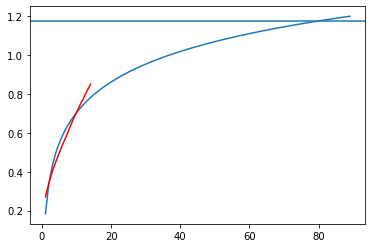

In [11]:
plt.plot(np.arange(1, 90), y_pred)
plt.plot(revenue.cohort_day, revenue.cum_arpu, color='red')
plt.axhline(cpi.cpi.sum()/data.customer_user_id.nunique())


In [12]:
predict = pd.DataFrame()
predict['cohort_day'] = np.arange(1, 90)
predict['y_pred'] = y_pred
predict['cpi'] = cpi.cpi.sum()/data.customer_user_id.nunique()
# predict['y']

predict[predict.y_pred>= predict.cpi]

cohort_day    y_pred       cpi
79          80  1.176385  1.174083
80          81  1.179202  1.174083
81          82  1.181984  1.174083
82          83  1.184732  1.174083
83          84  1.187447  1.174083
84          85  1.190130  1.174083
85          86  1.192782  1.174083
86          87  1.195403  1.174083
87          88  1.197994  1.174083
88          89  1.200556  1.174083

In [13]:
# Когда фактически эта закупка окупилась? 

sql = '''
SELECT user_id as customer_user_id, platform, media_source, campaign, 
    first_cohort_date as install_date, cpi, transaction_date as visit_date,
    value as revenue 
FROM `goingtoclouds.ltv.pareto_nbd_transactions`
where campaign = 'HC|Android|retention|US' and label = 'actual_data'
    and first_cohort_date <= '2020-09-16' 
'''
fact = client.query(sql, project=project_id).to_dataframe()


In [14]:
# Добавляем когортный день
fact['cohort_day'] = (fact.visit_date-fact.install_date).dt.days

# Считаем выручку на каждый день визита
revenue_fact = fact.groupby('cohort_day').revenue.sum().reset_index()
revenue_fact['cum_revenue'] = revenue_fact.revenue.cumsum()
revenue_fact['cum_arpu'] = revenue_fact['cum_revenue']/fact.customer_user_id.nunique()
revenue_fact['cpi'] =  cpi.cpi.sum()/data.customer_user_id.nunique()


In [15]:
revenue_fact[revenue_fact.cum_arpu<= revenue_fact.cpi]

cohort_day     revenue  cum_revenue  cum_arpu       cpi
0            0  186.831189   186.831189  0.172992  1.174083
1            1   98.161753   284.992942  0.263882  1.174083
2            2   72.994128   357.987071  0.331470  1.174083
3            3   66.161326   424.148396  0.392730  1.174083
4            4   50.319261   474.467657  0.439322  1.174083
5            5   48.513329   522.980986  0.484242  1.174083
6            6   46.779029   569.760015  0.527556  1.174083
7            7   41.439141   611.199157  0.565925  1.174083
8            8   47.430057   658.629214  0.609842  1.174083
9            9   44.473723   703.102937  0.651021  1.174083
10          10   38.930202   742.033138  0.687068  1.174083
11          11   40.361815   782.394953  0.724440  1.174083
12          12   36.599939   818.994892  0.758329  1.174083
13          13   38.045398   857.040290  0.793556  1.174083
14          14   37.039316   894.079606  0.827851  1.174083
15          15   27.081821   921.161427  0.852927  1.174083
16          16   29.130298   950.291725  0.879900  1.174083
17          17   27.682850   977.974575  0.905532  1.174083
18          18   31.450927  1009.425501  0.934653  1.174083
19          19   30.074597  1039.500098  0.962500  1.174083
20          20   26.253248  1065.753346  0.986809  1.174083
21          21   27.924252  1093.677598  1.012664  1.174083
22          22   27.550129  1121.227727  1.038174  1.174083
23          23   30.479776  1151.707503  1.066396  1.174083
24          24   29.255893  1180.963395  1.093485  1.174083
25          25   24.390339  1205.353734  1.116068  1.174083
26          26   29.177711  1234.531445  1.143085  1.174083
27          27   27.579958  1262.111403  1.168622  1.174083

### Задание 2

In [76]:
sql = '''
SELECT date, media_source, campaign, country_code, users, spend
FROM `goingtoclouds.spend_data_from_all_sources.agg_ga_spend` 
WHERE date between "2020-09-01" and "2020-10-01"
and campaign in ('HC|inst|US|all|05.09', 'HC|Android|inst+event|09.09', 'HC|US+UK+AU+CA|11.09|inst+all', 'HC_Andr_17.07')
'''
spend = client.query(sql, project=project_id).to_dataframe()
spend.to_csv("spend.csv")

In [78]:
sql = '''
SELECT user_id as customer_user_id, platform, media_source, campaign, first_cohort_date as install_date, 
transaction_date as visit_date, value as revenue, country_code
FROM `goingtoclouds.ltv.new_pareto_nbd_transactions` 
where campaign in ('HC|inst|US|all|05.09', 'HC|Android|inst+event|09.09', 'HC|US+UK+AU+CA|11.09|inst+all', 'HC_Andr_17.07')
and first_cohort_date  between "2020-09-01" and "2020-10-01" 
and label = 'actual_data'
and transaction_date <= '2020-12-31'
'''
revenue = client.query(sql, project=project_id).to_dataframe()
revenue.to_csv("revenue.csv")

In [79]:
revenue 

customer_user_id platform       media_source  \
0                 307300  android  googleadwords_int   
1                 307300  android  googleadwords_int   
2                 295236      ios  googleadwords_int   
3                 268631      ios  googleadwords_int   
4                 295236      ios  googleadwords_int   
...                  ...      ...                ...   
329016            242994      ios  googleadwords_int   
329017            243113      ios  googleadwords_int   
329018            243606      ios  googleadwords_int   
329019            243499      ios  googleadwords_int   
329020            243530      ios  googleadwords_int   

                             campaign install_date  visit_date   revenue  \
0                       HC_Andr_17.07   2020-10-01  2020-10-02  0.000120   
1                       HC_Andr_17.07   2020-10-01  2020-10-01  0.000004   
2                HC|inst|US|all|05.09   2020-09-28  2020-12-20  0.056590   
3                HC|inst|US|all|05.09   2020-09-22  2020-11-15  0.030645   
4                HC|inst|US|all|05.09   2020-09-28  2020-11-07  0.027607   
...                               ...          ...         ...       ...   
329016  HC|US+UK+AU+CA|11.09|inst+all   2020-09-15  2020-10-23  0.113240   
329017  HC|US+UK+AU+CA|11.09|inst+all   2020-09-15  2020-10-28  0.347541   
329018  HC|US+UK+AU+CA|11.09|inst+all   2020-09-15  2020-12-01  0.057516   
329019  HC|US+UK+AU+CA|11.09|inst+all   2020-09-15  2020-12-10  0.208684   
329020  HC|US+UK+AU+CA|11.09|inst+all   2020-09-15  2020-12-21  0.082530   

       country_code  
0                RS  
1                RS  
2                MX  
3                VI  
4                MX  
...             ...  
329016           UK  
329017           UK  
329018           UK  
329019           UK  
329020           UK  

[329021 rows x 8 columns]

In [80]:
spend

date       media_source                       campaign  \
0    2020-09-30  googleadwords_int  HC|US+UK+AU+CA|11.09|inst+all   
1    2020-09-30  googleadwords_int  HC|US+UK+AU+CA|11.09|inst+all   
2    2020-09-30  googleadwords_int  HC|US+UK+AU+CA|11.09|inst+all   
3    2020-09-30  googleadwords_int  HC|US+UK+AU+CA|11.09|inst+all   
4    2020-09-30  googleadwords_int           HC|inst|US|all|05.09   
..          ...                ...                            ...   
160  2020-09-27  googleadwords_int    HC|Android|inst+event|09.09   
161  2020-09-03  googleadwords_int                  HC_Andr_17.07   
162  2020-09-01  googleadwords_int                  HC_Andr_17.07   
163  2020-09-05  googleadwords_int           HC|inst|US|all|05.09   
164  2020-09-05  googleadwords_int                  HC_Andr_17.07   

    country_code  users   spend  
0             AU     12   12.99  
1             CA     20   26.51  
2             UK     70   67.41  
3             US      2    3.37  
4             US    236  443.09  
..           ...    ...     ...  
160           US    636  677.61  
161           US     82   59.43  
162           US     37   21.79  
163           US     97  200.42  
164           US    138  128.82  

[165 rows x 6 columns]